In [24]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
import colorsys
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

In [25]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img , img_to_array
import cv2
import random

label_map = {
    "person": "blue",
    "bicycle": "yellow", 
    "car": "red",
    "truck": "green",
    "motorbike": "white", 
    "aeroplane": "white", 
    "bus": "white",
    "train": "white", 
    "boat": "white"
}
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# Preprocess the given image
def image_preprocess(image, target_size):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    image_expanded = expand_dims(image_paded, 0)

    return image_expanded, w, h
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=label_map[v_labels[i]])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color=label_map[v_labels[i]])
    # show the plot
    pyplot.show()
    
def draw_bbox(image, bboxes, CLASSES, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = CLASSES
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

In [26]:
NUM_CLASS = {
    0: 'person',
    1: 'bicycle',
    2: 'car',
    3: 'motorbike',
    4: 'aeroplane',
    5: 'bus',
    6: 'train',
    7: 'truck',
    8: 'boat',
    9: 'traffic-light',
    10: 'fire-hydrant',
    11: 'stop-sign',
    12: 'parking-meter',
    13: 'bench',
    14: 'bird',
    15: 'cat',
    16: 'dog',
    17: 'horse',
    18: 'sheep',
    19: 'cow',
    20: 'elephant',
    21: 'bear',
    22: 'zebra',
    23: 'giraffe',
    24: 'backpack',
    25: 'umbrella',
    26: 'handbag',
    27: 'tie',
    28: 'suitcase',
    29: 'frisbee',
    30: 'skis',
    31: 'snowboard',
    32: 'sports-ball',
    33: 'kite',
    34: 'baseball-bat',
    35: 'baseball-glove',
    36: 'skateboard',
    37: 'surfboard',
    38: 'tennis-racket',
    39: 'bottle',
    40: 'wine-glass',
    41: 'cup',
    42: 'fork',
    43: 'knife',
    44: 'spoon',
    45: 'bowl',
    46: 'banana',
    47: 'apple',
    48: 'sandwich',
    49: 'orange',
    50: 'broccoli',
    51: 'carrot',
    52: 'hot-dog',
    53: 'pizza',
    54: 'donut',
    55: 'cake',
    56: 'chair',
    57: 'sofa',
    58: 'pottedplant',
    59: 'bed',
    60: 'diningtable',
    61: 'toilet',
    62: 'tvmonitor',
    63: 'laptop',
    64: 'mouse',
    65: 'remote',
    66: 'keyboard',
    67: 'cell-phone',
    68: 'microwave',
    69: 'oven',
    70: 'toaster',
    71: 'sink',
    72: 'refrigerator',
    73: 'book',
    74: 'clock',
    75: 'vase',
    76: 'scissors',
    77: 'teddy-bear', 
    78: 'hair-drier',
    79: 'toothbrush'
}

In [27]:
#!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights

In [28]:
#!curl -o yolov3.weights https://pjreddie.com/media/files/yolov3.weights

In [29]:
# define the model
model = make_yolov3_model()

# load the model weights
# I have loaded the pretrained weights in a separate dataset
weight_reader = WeightReader('yolov3.weights')

# set the model weights into the model
weight_reader.load_weights(model)

# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [30]:
# load yolov3 model
from keras.models import load_model
model = load_model('model.h5')

In [31]:
# Manual compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# Parameters used in the Dataset, on which YOLOv3 was pretrained
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the expected input shape for the model
WIDTH, HEIGHT = 512, 512

# define the probability threshold for detected objects
class_threshold = 0.8

In [33]:
import os
import errno
import argparse
import numpy as np
import cv2
import tensorflow.compat.v1 as tf
import scipy.linalg
from scipy.optimize import linear_sum_assignment

In [34]:
class Detection(object):
    """
    This class represents a bounding box detection in a single image.
    Parameters
    ----------
    tlwh : array_like
        Bounding box in format `(x, y, w, h)`.
    confidence : float
        Detector confidence score.
    feature : array_like
        A feature vector that describes the object contained in this image.
    Attributes
    ----------
    tlwh : ndarray
        Bounding box in format `(top left x, top left y, width, height)`.
    confidence : ndarray
        Detector confidence score.
    class_name : ndarray
        Detector class.
    feature : ndarray | NoneType
        A feature vector that describes the object contained in this image.
    """

    def __init__(self, tlwh, confidence, class_name, feature):
        #self.tlwh = np.asarray(tlwh, dtype=np.float)
        self.tlwh = np.asarray(tlwh, dtype=float)
        self.confidence = float(confidence)
        self.class_name = class_name
        self.feature = np.asarray(feature, dtype=np.float32)

    def get_class(self):
        return self.class_name

    def to_tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    def to_xyah(self):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = self.tlwh.copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

class ImageEncoder(object):

    def __init__(self, checkpoint_filename, input_name="images", output_name="features"):
        self.session = tf.Session()
        with tf.gfile.GFile(checkpoint_filename, "rb") as file_handle:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(file_handle.read())
        tf.import_graph_def(graph_def)
        try:
            self.input_var = tf.get_default_graph().get_tensor_by_name(input_name)
            self.output_var = tf.get_default_graph().get_tensor_by_name(output_name)
        except KeyError:
            layers = [i.name for i in tf.get_default_graph().get_operations()]
            self.input_var = tf.get_default_graph().get_tensor_by_name(layers[0]+':0')
            self.output_var = tf.get_default_graph().get_tensor_by_name(layers[-1]+':0')            

        assert len(self.output_var.get_shape()) == 2
        assert len(self.input_var.get_shape()) == 4
        self.feature_dim = self.output_var.get_shape().as_list()[-1]
        self.image_shape = self.input_var.get_shape().as_list()[1:]

    def __call__(self, data_x, batch_size=32):
        out = np.zeros((len(data_x), self.feature_dim), np.float32)
        _run_in_batches(
            lambda x: self.session.run(self.output_var, feed_dict=x),
            {self.input_var: data_x}, out, batch_size)
        return out

In [35]:
def _run_in_batches(f, data_dict, out, batch_size):
    data_len = len(out)
    num_batches = int(data_len / batch_size)

    s, e = 0, 0
    for i in range(num_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        batch_data_dict = {k: v[s:e] for k, v in data_dict.items()}
        out[s:e] = f(batch_data_dict)
    if e < len(out):
        batch_data_dict = {k: v[e:] for k, v in data_dict.items()}
        out[e:] = f(batch_data_dict)


def extract_image_patch(image, bbox, patch_shape):
    """Extract image patch from bounding box.
    Parameters
    ----------
    image : ndarray
        The full image.
    bbox : array_like
        The bounding box in format (x, y, width, height).
    patch_shape : Optional[array_like]
        This parameter can be used to enforce a desired patch shape
        (height, width). First, the `bbox` is adapted to the aspect ratio
        of the patch shape, then it is clipped at the image boundaries.
        If None, the shape is computed from :arg:`bbox`.
    Returns
    -------
    ndarray | NoneType
        An image patch showing the :arg:`bbox`, optionally reshaped to
        :arg:`patch_shape`.
        Returns None if the bounding box is empty or fully outside of the image
        boundaries.
    """
    bbox = np.array(bbox)
    if patch_shape is not None:
        # correct aspect ratio to patch shape
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

    # convert to top left, bottom right
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(int) #modified
    # bbox = bbox.astype(np.int)

    # clip at image boundaries
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    image = image[sy:ey, sx:ex]
    image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image

def create_box_encoder(model_filename, input_name="images:0", output_name="features:0", batch_size=32):
    image_encoder = ImageEncoder(model_filename, input_name, output_name)
    image_shape = image_encoder.image_shape

    def encoder(image, boxes):
        image_patches = []
        for box in boxes:
            patch = extract_image_patch(image, box, image_shape[:2])
            if patch is None:
                print("WARNING: Failed to extract image patch: %s." % str(box))
                patch = np.random.uniform(0., 255., image_shape).astype(np.uint8)
            image_patches.append(patch)
        image_patches = np.asarray(image_patches)
        return image_encoder(image_patches, batch_size)

    return encoder


def generate_detections(encoder, mot_dir, output_dir, detection_dir=None):
    """Generate detections with features.
    Parameters
    ----------
    encoder : Callable[image, ndarray] -> ndarray
        The encoder function takes as input a BGR color image and a matrix of
        bounding boxes in format `(x, y, w, h)` and returns a matrix of
        corresponding feature vectors.
    mot_dir : str
        Path to the MOTChallenge directory (can be either train or test).
    output_dir
        Path to the output directory. Will be created if it does not exist.
    detection_dir
        Path to custom detections. The directory structure should be the default
        MOTChallenge structure: `[sequence]/det/det.txt`. If None, uses the
        standard MOTChallenge detections.
    """
    if detection_dir is None:
        detection_dir = mot_dir
    try:
        os.makedirs(output_dir)
    except OSError as exception:
        if exception.errno == errno.EEXIST and os.path.isdir(output_dir):
            pass
        else:
            raise ValueError(
                "Failed to created output directory '%s'" % output_dir)

    for sequence in os.listdir(mot_dir):
        print("Processing %s" % sequence)
        sequence_dir = os.path.join(mot_dir, sequence)

        image_dir = os.path.join(sequence_dir, "img1")
        image_filenames = {
            int(os.path.splitext(f)[0]): os.path.join(image_dir, f)
            for f in os.listdir(image_dir)}

        detection_file = os.path.join(
            detection_dir, sequence, "det/det.txt")
        detections_in = np.loadtxt(detection_file, delimiter=',')
        detections_out = []

        frame_indices = detections_in[:, 0].astype(np.int)
        min_frame_idx = frame_indices.astype(np.int).min()
        max_frame_idx = frame_indices.astype(np.int).max()
        for frame_idx in range(min_frame_idx, max_frame_idx + 1):
            print("Frame %05d/%05d" % (frame_idx, max_frame_idx))
            mask = frame_indices == frame_idx
            rows = detections_in[mask]

            if frame_idx not in image_filenames:
                print("WARNING could not find image for frame %d" % frame_idx)
                continue
            bgr_image = cv2.imread(
                image_filenames[frame_idx], cv2.IMREAD_COLOR)
            features = encoder(bgr_image, rows[:, 2:6].copy())
            detections_out += [np.r_[(row, feature)] for row, feature
                               in zip(rows, features)]

        output_filename = os.path.join(output_dir, "%s.npy" % sequence)
        np.save(
            output_filename, np.asarray(detections_out), allow_pickle=False)

In [36]:
!wget https://github.com/anushkadhiman/ObjectTracking-DeepSORT-YOLOv3-TF2/raw/master/model_data/coco/mars-small128.pb

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
"""
Table for the 0.95 quantile of the chi-square distribution with N degrees of
freedom (contains values for N=1, ..., 9). Taken from MATLAB/Octave's chi2inv
function and used as Mahalanobis gating threshold.
"""
chi2inv95 = {
    1: 3.8415,
    2: 5.9915,
    3: 7.8147,
    4: 9.4877,
    5: 11.070,
    6: 12.592,
    7: 14.067,
    8: 15.507,
    9: 16.919}


class KalmanFilter(object):
    """
    A simple Kalman filter for tracking bounding boxes in image space.
    The 8-dimensional state space
        x, y, a, h, vx, vy, va, vh
    contains the bounding box center position (x, y), aspect ratio a, height h,
    and their respective velocities.
    Object motion follows a constant velocity model. The bounding box location
    (x, y, a, h) is taken as direct observation of the state space (linear
    observation model).
    """

    def __init__(self):
        ndim, dt = 4, 1.

        # Create Kalman filter model matrices.
        self._motion_mat = np.eye(2 * ndim, 2 * ndim)
        for i in range(ndim):
            self._motion_mat[i, ndim + i] = dt
        self._update_mat = np.eye(ndim, 2 * ndim)

        # Motion and observation uncertainty are chosen relative to the current
        # state estimate. These weights control the amount of uncertainty in
        # the model. This is a bit hacky.
        self._std_weight_position = 1. / 20
        self._std_weight_velocity = 1. / 160

    def initiate(self, measurement):
        """Create track from unassociated measurement.
        Parameters
        ----------
        measurement : ndarray
            Bounding box coordinates (x, y, a, h) with center position (x, y),
            aspect ratio a, and height h.
        Returns
        -------
        (ndarray, ndarray)
            Returns the mean vector (8 dimensional) and covariance matrix (8x8
            dimensional) of the new track. Unobserved velocities are initialized
            to 0 mean.
        """
        mean_pos = measurement
        mean_vel = np.zeros_like(mean_pos)
        mean = np.r_[mean_pos, mean_vel]

        std = [
            2 * self._std_weight_position * measurement[3],
            2 * self._std_weight_position * measurement[3],
            1e-2,
            2 * self._std_weight_position * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            1e-5,
            10 * self._std_weight_velocity * measurement[3]]
        covariance = np.diag(np.square(std))
        return mean, covariance

    def predict(self, mean, covariance):
        """Run Kalman filter prediction step.
        Parameters
        ----------
        mean : ndarray
            The 8 dimensional mean vector of the object state at the previous
            time step.
        covariance : ndarray
            The 8x8 dimensional covariance matrix of the object state at the
            previous time step.
        Returns
        -------
        (ndarray, ndarray)
            Returns the mean vector and covariance matrix of the predicted
            state. Unobserved velocities are initialized to 0 mean.
        """
        std_pos = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-2,
            self._std_weight_position * mean[3]]
        std_vel = [
            self._std_weight_velocity * mean[3],
            self._std_weight_velocity * mean[3],
            1e-5,
            self._std_weight_velocity * mean[3]]
        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))

        mean = np.dot(self._motion_mat, mean)
        covariance = np.linalg.multi_dot((
            self._motion_mat, covariance, self._motion_mat.T)) + motion_cov

        return mean, covariance

    def project(self, mean, covariance):
        """Project state distribution to measurement space.
        Parameters
        ----------
        mean : ndarray
            The state's mean vector (8 dimensional array).
        covariance : ndarray
            The state's covariance matrix (8x8 dimensional).
        Returns
        -------
        (ndarray, ndarray)
            Returns the projected mean and covariance matrix of the given state
            estimate.
        """
        std = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-1,
            self._std_weight_position * mean[3]]
        innovation_cov = np.diag(np.square(std))

        mean = np.dot(self._update_mat, mean)
        covariance = np.linalg.multi_dot((
            self._update_mat, covariance, self._update_mat.T))
        return mean, covariance + innovation_cov

    def update(self, mean, covariance, measurement):
        """Run Kalman filter correction step.
        Parameters
        ----------
        mean : ndarray
            The predicted state's mean vector (8 dimensional).
        covariance : ndarray
            The state's covariance matrix (8x8 dimensional).
        measurement : ndarray
            The 4 dimensional measurement vector (x, y, a, h), where (x, y)
            is the center position, a the aspect ratio, and h the height of the
            bounding box.
        Returns
        -------
        (ndarray, ndarray)
            Returns the measurement-corrected state distribution.
        """
        projected_mean, projected_cov = self.project(mean, covariance)

        chol_factor, lower = scipy.linalg.cho_factor(
            projected_cov, lower=True, check_finite=False)
        kalman_gain = scipy.linalg.cho_solve(
            (chol_factor, lower), np.dot(covariance, self._update_mat.T).T,
            check_finite=False).T
        innovation = measurement - projected_mean

        new_mean = mean + np.dot(innovation, kalman_gain.T)
        new_covariance = covariance - np.linalg.multi_dot((
            kalman_gain, projected_cov, kalman_gain.T))
        return new_mean, new_covariance

    def gating_distance(self, mean, covariance, measurements,
                        only_position=False):
        """Compute gating distance between state distribution and measurements.
        A suitable distance threshold can be obtained from `chi2inv95`. If
        `only_position` is False, the chi-square distribution has 4 degrees of
        freedom, otherwise 2.
        Parameters
        ----------
        mean : ndarray
            Mean vector over the state distribution (8 dimensional).
        covariance : ndarray
            Covariance of the state distribution (8x8 dimensional).
        measurements : ndarray
            An Nx4 dimensional matrix of N measurements, each in
            format (x, y, a, h) where (x, y) is the bounding box center
            position, a the aspect ratio, and h the height.
        only_position : Optional[bool]
            If True, distance computation is done with respect to the bounding
            box center position only.
        Returns
        -------
        ndarray
            Returns an array of length N, where the i-th element contains the
            squared Mahalanobis distance between (mean, covariance) and
            `measurements[i]`.
        """
        mean, covariance = self.project(mean, covariance)
        if only_position:
            mean, covariance = mean[:2], covariance[:2, :2]
            measurements = measurements[:, :2]

        cholesky_factor = np.linalg.cholesky(covariance)
        d = measurements - mean
        z = scipy.linalg.solve_triangular(
            cholesky_factor, d.T, lower=True, check_finite=False,
            overwrite_b=True)
        squared_maha = np.sum(z * z, axis=0)
        return squared_maha

In [38]:
INFTY_COST = 1e+5


def min_cost_matching(
        distance_metric, max_distance, tracks, detections, track_indices=None,
        detection_indices=None):
    """Solve linear assignment problem.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection_indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : List[int]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above).
    detection_indices : List[int]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above).
    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    if len(detection_indices) == 0 or len(track_indices) == 0:
        return [], track_indices, detection_indices  # Nothing to match.

    cost_matrix = distance_metric(
        tracks, detections, track_indices, detection_indices)
    cost_matrix[cost_matrix > max_distance] = max_distance + 1e-5
    indices = linear_sum_assignment(cost_matrix)
    indices = np.asarray(indices)
    indices = np.transpose(indices)
    matches, unmatched_tracks, unmatched_detections = [], [], []
    for col, detection_idx in enumerate(detection_indices):
        if col not in indices[:, 1]:
            unmatched_detections.append(detection_idx)
    for row, track_idx in enumerate(track_indices):
        if row not in indices[:, 0]:
            unmatched_tracks.append(track_idx)
    for row, col in indices:
        track_idx = track_indices[row]
        detection_idx = detection_indices[col]
        if cost_matrix[row, col] > max_distance:
            unmatched_tracks.append(track_idx)
            unmatched_detections.append(detection_idx)
        else:
            matches.append((track_idx, detection_idx))
    return matches, unmatched_tracks, unmatched_detections


def matching_cascade(
        distance_metric, max_distance, cascade_depth, tracks, detections,
        track_indices=None, detection_indices=None):
    """Run matching cascade.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    cascade_depth: int
        The cascade depth, should be se to the maximum track age.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : Optional[List[int]]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above). Defaults to all tracks.
    detection_indices : Optional[List[int]]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above). Defaults to all
        detections.
    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    if track_indices is None:
        track_indices = list(range(len(tracks)))
    if detection_indices is None:
        detection_indices = list(range(len(detections)))

    unmatched_detections = detection_indices
    matches = []
    for level in range(cascade_depth):
        if len(unmatched_detections) == 0:  # No detections left
            break

        track_indices_l = [
            k for k in track_indices
            if tracks[k].time_since_update == 1 + level
        ]
        if len(track_indices_l) == 0:  # Nothing to match at this level
            continue

        matches_l, _, unmatched_detections = \
            min_cost_matching(
                distance_metric, max_distance, tracks, detections,
                track_indices_l, unmatched_detections)
        matches += matches_l
    unmatched_tracks = list(set(track_indices) - set(k for k, _ in matches))
    return matches, unmatched_tracks, unmatched_detections


def gate_cost_matrix(
        kf, cost_matrix, tracks, detections, track_indices, detection_indices,
        gated_cost=INFTY_COST, only_position=False):
    """Invalidate infeasible entries in cost matrix based on the state
    distributions obtained by Kalman filtering.
    Parameters
    ----------
    kf : The Kalman filter.
    cost_matrix : ndarray
        The NxM dimensional cost matrix, where N is the number of track indices
        and M is the number of detection indices, such that entry (i, j) is the
        association cost between `tracks[track_indices[i]]` and
        `detections[detection_indices[j]]`.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : List[int]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above).
    detection_indices : List[int]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above).
    gated_cost : Optional[float]
        Entries in the cost matrix corresponding to infeasible associations are
        set this value. Defaults to a very large value.
    only_position : Optional[bool]
        If True, only the x, y position of the state distribution is considered
        during gating. Defaults to False.
    Returns
    -------
    ndarray
        Returns the modified cost matrix.
    """
    gating_dim = 2 if only_position else 4
    gating_threshold = chi2inv95[gating_dim]
    measurements = np.asarray(
        [detections[i].to_xyah() for i in detection_indices])
    for row, track_idx in enumerate(track_indices):
        track = tracks[track_idx]
        gating_distance = kf.gating_distance(
            track.mean, track.covariance, measurements, only_position)
        cost_matrix[row, gating_distance > gating_threshold] = gated_cost
    return cost_matrix

In [39]:
def iou(bbox, candidates):
    """Computer intersection over union.
    Parameters
    ----------
    bbox : ndarray
        A bounding box in format `(top left x, top left y, width, height)`.
    candidates : ndarray
        A matrix of candidate bounding boxes (one per row) in the same format
        as `bbox`.
    Returns
    -------
    ndarray
        The intersection over union in [0, 1] between the `bbox` and each
        candidate. A higher score means a larger fraction of the `bbox` is
        occluded by the candidate.
    """
    bbox_tl, bbox_br = bbox[:2], bbox[:2] + bbox[2:]
    candidates_tl = candidates[:, :2]
    candidates_br = candidates[:, :2] + candidates[:, 2:]

    tl = np.c_[np.maximum(bbox_tl[0], candidates_tl[:, 0])[:, np.newaxis],
               np.maximum(bbox_tl[1], candidates_tl[:, 1])[:, np.newaxis]]
    br = np.c_[np.minimum(bbox_br[0], candidates_br[:, 0])[:, np.newaxis],
               np.minimum(bbox_br[1], candidates_br[:, 1])[:, np.newaxis]]
    wh = np.maximum(0., br - tl)

    area_intersection = wh.prod(axis=1)
    area_bbox = bbox[2:].prod()
    area_candidates = candidates[:, 2:].prod(axis=1)
    return area_intersection / (area_bbox + area_candidates - area_intersection)


def iou_cost(tracks, detections, track_indices=None,
             detection_indices=None):
    """An intersection over union distance metric.
    Parameters
    ----------
    tracks : List[deep_sort.track.Track]
        A list of tracks.
    detections : List[deep_sort.detection.Detection]
        A list of detections.
    track_indices : Optional[List[int]]
        A list of indices to tracks that should be matched. Defaults to
        all `tracks`.
    detection_indices : Optional[List[int]]
        A list of indices to detections that should be matched. Defaults
        to all `detections`.
    Returns
    -------
    ndarray
        Returns a cost matrix of shape
        len(track_indices), len(detection_indices) where entry (i, j) is
        `1 - iou(tracks[track_indices[i]], detections[detection_indices[j]])`.
    """
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    cost_matrix = np.zeros((len(track_indices), len(detection_indices)))
    for row, track_idx in enumerate(track_indices):
        if tracks[track_idx].time_since_update > 1:
            cost_matrix[row, :] = linear_assignment.INFTY_COST
            continue

        bbox = tracks[track_idx].to_tlwh()
        candidates = np.asarray([detections[i].tlwh for i in detection_indices])
        cost_matrix[row, :] = 1. - iou(bbox, candidates)
    return cost_matrix

In [40]:
def non_max_suppression(boxes, classes, max_bbox_overlap, scores=None):
    """Suppress overlapping detections.
    Original code from [1]_ has been adapted to include confidence score.
    .. [1] http://www.pyimagesearch.com/2015/02/16/
           faster-non-maximum-suppression-python/
    Examples
    --------
        >>> boxes = [d.roi for d in detections]
        >>> classes = [d.classes for d in detections]
        >>> scores = [d.confidence for d in detections]
        >>> indices = non_max_suppression(boxes, max_bbox_overlap, scores)
        >>> detections = [detections[i] for i in indices]
    Parameters
    ----------
    boxes : ndarray
        Array of ROIs (x, y, width, height).
    max_bbox_overlap : float
        ROIs that overlap more than this values are suppressed.
    scores : Optional[array_like]
        Detector confidence score.
    Returns
    -------
    List[int]
        Returns indices of detections that have survived non-maxima suppression.
    """
    if len(boxes) == 0:
        return []

    boxes = boxes.astype(np.float)
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + boxes[:, 0]
    y2 = boxes[:, 3] + boxes[:, 1]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    if scores is not None:
        idxs = np.argsort(scores)
    else:
        idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(
            idxs, np.concatenate(
                ([last], np.where(overlap > max_bbox_overlap)[0])))

    return pick

In [41]:
def _pdist(a, b):
    """Compute pair-wise squared distance between points in `a` and `b`.
    Parameters
    ----------
    a : array_like
        An NxM matrix of N samples of dimensionality M.
    b : array_like
        An LxM matrix of L samples of dimensionality M.
    Returns
    -------
    ndarray
        Returns a matrix of size len(a), len(b) such that eleement (i, j)
        contains the squared distance between `a[i]` and `b[j]`.
    """
    a, b = np.asarray(a), np.asarray(b)
    if len(a) == 0 or len(b) == 0:
        return np.zeros((len(a), len(b)))
    a2, b2 = np.square(a).sum(axis=1), np.square(b).sum(axis=1)
    r2 = -2. * np.dot(a, b.T) + a2[:, None] + b2[None, :]
    r2 = np.clip(r2, 0., float(np.inf))
    return r2


def _cosine_distance(a, b, data_is_normalized=False):
    """Compute pair-wise cosine distance between points in `a` and `b`.
    Parameters
    ----------
    a : array_like
        An NxM matrix of N samples of dimensionality M.
    b : array_like
        An LxM matrix of L samples of dimensionality M.
    data_is_normalized : Optional[bool]
        If True, assumes rows in a and b are unit length vectors.
        Otherwise, a and b are explicitly normalized to lenght 1.
    Returns
    -------
    ndarray
        Returns a matrix of size len(a), len(b) such that eleement (i, j)
        contains the squared distance between `a[i]` and `b[j]`.
    """
    if not data_is_normalized:
        a = np.asarray(a) / np.linalg.norm(a, axis=1, keepdims=True)
        b = np.asarray(b) / np.linalg.norm(b, axis=1, keepdims=True)
    return 1. - np.dot(a, b.T)


def _nn_euclidean_distance(x, y):
    """ Helper function for nearest neighbor distance metric (Euclidean).
    Parameters
    ----------
    x : ndarray
        A matrix of N row-vectors (sample points).
    y : ndarray
        A matrix of M row-vectors (query points).
    Returns
    -------
    ndarray
        A vector of length M that contains for each entry in `y` the
        smallest Euclidean distance to a sample in `x`.
    """
    distances = _pdist(x, y)
    return np.maximum(0.0, distances.min(axis=0))


def _nn_cosine_distance(x, y):
    """ Helper function for nearest neighbor distance metric (cosine).
    Parameters
    ----------
    x : ndarray
        A matrix of N row-vectors (sample points).
    y : ndarray
        A matrix of M row-vectors (query points).
    Returns
    -------
    ndarray
        A vector of length M that contains for each entry in `y` the
        smallest cosine distance to a sample in `x`.
    """
    distances = _cosine_distance(x, y)
    return distances.min(axis=0)


class NearestNeighborDistanceMetric(object):
    """
    A nearest neighbor distance metric that, for each target, returns
    the closest distance to any sample that has been observed so far.
    Parameters
    ----------
    metric : str
        Either "euclidean" or "cosine".
    matching_threshold: float
        The matching threshold. Samples with larger distance are considered an
        invalid match.
    budget : Optional[int]
        If not None, fix samples per class to at most this number. Removes
        the oldest samples when the budget is reached.
    Attributes
    ----------
    samples : Dict[int -> List[ndarray]]
        A dictionary that maps from target identities to the list of samples
        that have been observed so far.
    """

    def __init__(self, metric, matching_threshold, budget=None):


        if metric == "euclidean":
            self._metric = _nn_euclidean_distance
        elif metric == "cosine":
            self._metric = _nn_cosine_distance
        else:
            raise ValueError(
                "Invalid metric; must be either 'euclidean' or 'cosine'")
        self.matching_threshold = matching_threshold
        self.budget = budget
        self.samples = {}

    def partial_fit(self, features, targets, active_targets):
        """Update the distance metric with new data.
        Parameters
        ----------
        features : ndarray
            An NxM matrix of N features of dimensionality M.
        targets : ndarray
            An integer array of associated target identities.
        active_targets : List[int]
            A list of targets that are currently present in the scene.
        """
        for feature, target in zip(features, targets):
            self.samples.setdefault(target, []).append(feature)
            if self.budget is not None:
                self.samples[target] = self.samples[target][-self.budget:]
        self.samples = {k: self.samples[k] for k in active_targets}

    def distance(self, features, targets):
        """Compute distance between features and targets.
        Parameters
        ----------
        features : ndarray
            An NxM matrix of N features of dimensionality M.
        targets : List[int]
            A list of targets to match the given `features` against.
        Returns
        -------
        ndarray
            Returns a cost matrix of shape len(targets), len(features), where
            element (i, j) contains the closest squared distance between
            `targets[i]` and `features[j]`.
        """
        cost_matrix = np.zeros((len(targets), len(features)))
        for i, target in enumerate(targets):
            cost_matrix[i, :] = self._metric(self.samples[target], features)
        return cost_matrix

In [42]:
class TrackState:
    """
    Enumeration type for the single target track state. Newly created tracks are
    classified as `tentative` until enough evidence has been collected. Then,
    the track state is changed to `confirmed`. Tracks that are no longer alive
    are classified as `deleted` to mark them for removal from the set of active
    tracks.
    """

    Tentative = 1
    Confirmed = 2
    Deleted = 3


class Track:
    """
    A single target track with state space `(x, y, a, h)` and associated
    velocities, where `(x, y)` is the center of the bounding box, `a` is the
    aspect ratio and `h` is the height.
    Parameters
    ----------
    mean : ndarray
        Mean vector of the initial state distribution.
    covariance : ndarray
        Covariance matrix of the initial state distribution.
    track_id : int
        A unique track identifier.
    n_init : int
        Number of consecutive detections before the track is confirmed. The
        track state is set to `Deleted` if a miss occurs within the first
        `n_init` frames.
    max_age : int
        The maximum number of consecutive misses before the track state is
        set to `Deleted`.
    feature : Optional[ndarray]
        Feature vector of the detection this track originates from. If not None,
        this feature is added to the `features` cache.
    Attributes
    ----------
    mean : ndarray
        Mean vector of the initial state distribution.
    covariance : ndarray
        Covariance matrix of the initial state distribution.
    track_id : int
        A unique track identifier.
    hits : int
        Total number of measurement updates.
    age : int
        Total number of frames since first occurance.
    time_since_update : int
        Total number of frames since last measurement update.
    state : TrackState
        The current track state.
    features : List[ndarray]
        A cache of features. On each measurement update, the associated feature
        vector is added to this list.
    """

    def __init__(self, mean, covariance, track_id, n_init, max_age,
                 feature=None, class_name=None):
        self.mean = mean
        self.covariance = covariance
        self.track_id = track_id
        self.hits = 1
        self.age = 1
        self.time_since_update = 0

        self.state = TrackState.Tentative
        self.features = []
        if feature is not None:
            self.features.append(feature)

        self._n_init = n_init
        self._max_age = max_age
        self.class_name = class_name

    def to_tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
        width, height)`.
        Returns
        -------
        ndarray
            The bounding box.
        """
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    def to_tlbr(self):
        """Get current position in bounding box format `(min x, miny, max x,
        max y)`.
        Returns
        -------
        ndarray
            The bounding box.
        """
        ret = self.to_tlwh()
        ret[2:] = ret[:2] + ret[2:]
        return ret
    
    def get_class(self):
        return self.class_name

    def predict(self, kf):
        """Propagate the state distribution to the current time step using a
        Kalman filter prediction step.
        Parameters
        ----------
        kf : kalman_filter.KalmanFilter
            The Kalman filter.
        """
        self.mean, self.covariance = kf.predict(self.mean, self.covariance)
        self.age += 1
        self.time_since_update += 1

    def update(self, kf, detection):
        """Perform Kalman filter measurement update step and update the feature
        cache.
        Parameters
        ----------
        kf : kalman_filter.KalmanFilter
            The Kalman filter.
        detection : Detection
            The associated detection.
        """
        self.mean, self.covariance = kf.update(
            self.mean, self.covariance, detection.to_xyah())
        self.features.append(detection.feature)

        self.hits += 1
        self.time_since_update = 0
        if self.state == TrackState.Tentative and self.hits >= self._n_init:
            self.state = TrackState.Confirmed

    def mark_missed(self):
        """Mark this track as missed (no association at the current time step).
        """
        if self.state == TrackState.Tentative:
            self.state = TrackState.Deleted
        elif self.time_since_update > self._max_age:
            self.state = TrackState.Deleted

    def is_tentative(self):
        """Returns True if this track is tentative (unconfirmed).
        """
        return self.state == TrackState.Tentative

    def is_confirmed(self):
        """Returns True if this track is confirmed."""
        return self.state == TrackState.Confirmed

    def is_deleted(self):
        """Returns True if this track is dead and should be deleted."""
        return self.state == TrackState.Deleted

In [43]:
class Tracker:
    """
    This is the multi-target tracker.
    Parameters
    ----------
    metric : nn_matching.NearestNeighborDistanceMetric
        A distance metric for measurement-to-track association.
    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of consecutive detections before the track is confirmed. The
        track state is set to `Deleted` if a miss occurs within the first
        `n_init` frames.
    Attributes
    ----------
    metric : nn_matching.NearestNeighborDistanceMetric
        The distance metric used for measurement to track association.
    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of frames that a track remains in initialization phase.
    kf : kalman_filter.KalmanFilter
        A Kalman filter to filter target trajectories in image space.
    tracks : List[Track]
        The list of active tracks at the current time step.
    """

    def __init__(self, metric, max_iou_distance=0.7, max_age=30, n_init=3):
        self.metric = metric
        self.max_iou_distance = max_iou_distance
        self.max_age = max_age
        self.n_init = n_init

        self.kf = KalmanFilter()
        self.tracks = []
        self._next_id = 1

    def predict(self):
        """Propagate track state distributions one time step forward.
        This function should be called once every time step, before `update`.
        """
        for track in self.tracks:
            track.predict(self.kf)

    def update(self, detections):
        """Perform measurement update and track management.
        Parameters
        ----------
        detections : List[deep_sort.detection.Detection]
            A list of detections at the current time step.
        """
        # Run matching cascade.
        matches, unmatched_tracks, unmatched_detections = \
            self._match(detections)

        # Update track set.
        for track_idx, detection_idx in matches:
            self.tracks[track_idx].update(
                self.kf, detections[detection_idx])
        for track_idx in unmatched_tracks:
            self.tracks[track_idx].mark_missed()
        for detection_idx in unmatched_detections:
            self._initiate_track(detections[detection_idx])
        self.tracks = [t for t in self.tracks if not t.is_deleted()]

        # Update distance metric.
        active_targets = [t.track_id for t in self.tracks if t.is_confirmed()]
        features, targets = [], []
        for track in self.tracks:
            if not track.is_confirmed():
                continue
            features += track.features
            targets += [track.track_id for _ in track.features]
            track.features = []
        self.metric.partial_fit(
            np.asarray(features), np.asarray(targets), active_targets)

    def _match(self, detections):

        def gated_metric(tracks, dets, track_indices, detection_indices):
            features = np.array([dets[i].feature for i in detection_indices])
            targets = np.array([tracks[i].track_id for i in track_indices])
            cost_matrix = self.metric.distance(features, targets)
            cost_matrix = gate_cost_matrix(
                self.kf, cost_matrix, tracks, dets, track_indices,
                detection_indices)

            return cost_matrix

        # Split track set into confirmed and unconfirmed tracks.
        confirmed_tracks = [
            i for i, t in enumerate(self.tracks) if t.is_confirmed()]
        unconfirmed_tracks = [
            i for i, t in enumerate(self.tracks) if not t.is_confirmed()]

        # Associate confirmed tracks using appearance features.
        matches_a, unmatched_tracks_a, unmatched_detections = \
                matching_cascade(
                gated_metric, self.metric.matching_threshold, self.max_age,
                self.tracks, detections, confirmed_tracks)

        # Associate remaining tracks together with unconfirmed tracks using IOU.
        iou_track_candidates = unconfirmed_tracks + [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update == 1]
        unmatched_tracks_a = [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update != 1]
        matches_b, unmatched_tracks_b, unmatched_detections = \
                min_cost_matching(
                iou_cost, self.max_iou_distance, self.tracks,
                detections, iou_track_candidates, unmatched_detections)

        matches = matches_a + matches_b
        unmatched_tracks = list(set(unmatched_tracks_a + unmatched_tracks_b))
        return matches, unmatched_tracks, unmatched_detections

    def _initiate_track(self, detection):
        mean, covariance = self.kf.initiate(detection.to_xyah())
        class_name = detection.get_class()
        self.tracks.append(Track(
            mean, covariance, self._next_id, self.n_init, self.max_age,
            detection.feature, class_name))
        self._next_id += 1

In [44]:
# Definition of the parameters
max_cosine_distance = 0.7
max_euclidean_distance = 0.7
nn_budget = None
model_filename = 'mars-small128.pb'

key_list = list(NUM_CLASS.keys()) 
val_list = list(NUM_CLASS.values()) 

In [45]:
import time

# Function for object tracking on video
def object_tracking(video_path, output_path):
    encoder = create_box_encoder(model_filename, batch_size=1)
    metric = NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)
    
    times, times_2 = [], []
    vid = cv2.VideoCapture(video_path) # detect on video

    # by default VideoCapture returns float instead of int
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    codec = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, codec, fps, (width, height)) # output_path must be .mp4
    
    while True:
        _, frame = vid.read()

        try:
            original_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            original_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
        except:
            break

        # Load picture with old dimensions
        image_data, image_w, image_h = image_preprocess(np.copy(original_frame), (WIDTH, HEIGHT))

        # Predict Image
        t1 = time.time()
        yhat = model.predict(image_data)

        # Create boxes
        boxes = list()
        for i in range(len(yhat)):
            boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

        # Correct the sizes of boxes for shape of image
        correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

        # Suppress Non Maximal Boxes
        do_nms(boxes, 0.3)

        # define the labels (Filtered only the ones relevant for this task, which were used in pretraining the YOLOv3 model)
        labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]

        # get the details of the detected objects
        v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


        #t1 = time.time()
        #pred_bbox = Yolo.predict(image_data)
        t2 = time.time()

        # Obtain all the detections for the given frame
        boxes = []
        names = []
        scores = []
        for box, label, score in zip(v_boxes, v_labels, v_scores):
            boxes.append([
                 box.xmin, box.ymin, 
                (box.xmax - box.xmin), (box.ymax - box.ymin) * 2])
            names.append(label)
            scores.append(score)

        boxes = np.array(boxes) 
        names = np.array(names)
        scores = np.array(scores)
        features = np.array(encoder(original_frame, boxes))
        detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in zip(boxes, scores, names, features)]

        # Pass detections to the deepsort object and obtain the track information.
        tracker.predict()
        tracker.update(detections)

        # Obtain info from the tracks
        tracked_bboxes = []
        for track in tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 5:
                continue 
            bbox = track.to_tlbr() # Get the corrected/predicted bounding box
            class_name = track.get_class() #Get the class name of particular object
            tracking_id = track.track_id # Get the ID for the particular track
            index = key_list[val_list.index(class_name)] # Get predicted object index by object name
            tracked_bboxes.append(bbox.tolist() + [tracking_id, index]) # Structure data, that we could use it with our draw_bbox function

        # draw detection on frame
        image = draw_bbox(original_frame, tracked_bboxes, CLASSES=NUM_CLASS, tracking=True)

        t3 = time.time()
        times.append(t2-t1)
        times_2.append(t3-t1)

        times = times[-20:]
        times_2 = times_2[-20:]

        ms = sum(times)/len(times)*1000
        fps = 1000 / ms
        fps2 = 1000 / (sum(times_2)/len(times_2)*1000)

        image = cv2.putText(image, "Time: {:.1f} FPS".format(fps), (0, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)

        # draw original yolo detection
        #image = draw_bbox(image, bboxes, CLASSES=CLASSES, show_label=False, rectangle_colors=rectangle_colors, tracking=True)

        print("Time: {:.2f}ms, Detection FPS: {:.1f}, total FPS: {:.1f}".format(ms, fps, fps2))
        out.write(image)

    out.release()
    vid.release()

In [46]:
# Process all Videos
import os

VIDEO_PATH = 'dataset/testing/'
videos = os.listdir(VIDEO_PATH)

number_of_videos_object_tracked_using_Kalman_Filter = 0

for video in videos:
    
    number_of_videos_object_tracked_using_Kalman_Filter = number_of_videos_object_tracked_using_Kalman_Filter
    print(f"Processing video {video}")
    object_tracking(VIDEO_PATH + video, video)
    
    if number_of_videos_object_tracked_using_Kalman_Filter >= 10 :
        
        break

Processing video challenge.mp4
1/1 [==============================] - 2s 2s/step
Time: 7780.89ms, Detection FPS: 0.1, total FPS: 0.1
1/1 [==============================] - 1s 614ms/step
Time: 6608.51ms, Detection FPS: 0.2, total FPS: 0.1
1/1 [==============================] - 1s 562ms/step
Time: 6022.34ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 565ms/step
Time: 5925.83ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 605ms/step
Time: 5990.77ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 675ms/step
Time: 6235.56ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 702ms/step
Time: 6287.93ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 588ms/step
Time: 6306.74ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 1s 601ms/step
Time: 6245.57ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [======================

KeyboardInterrupt: 

TypeError: Image data of dtype object cannot be converted to float

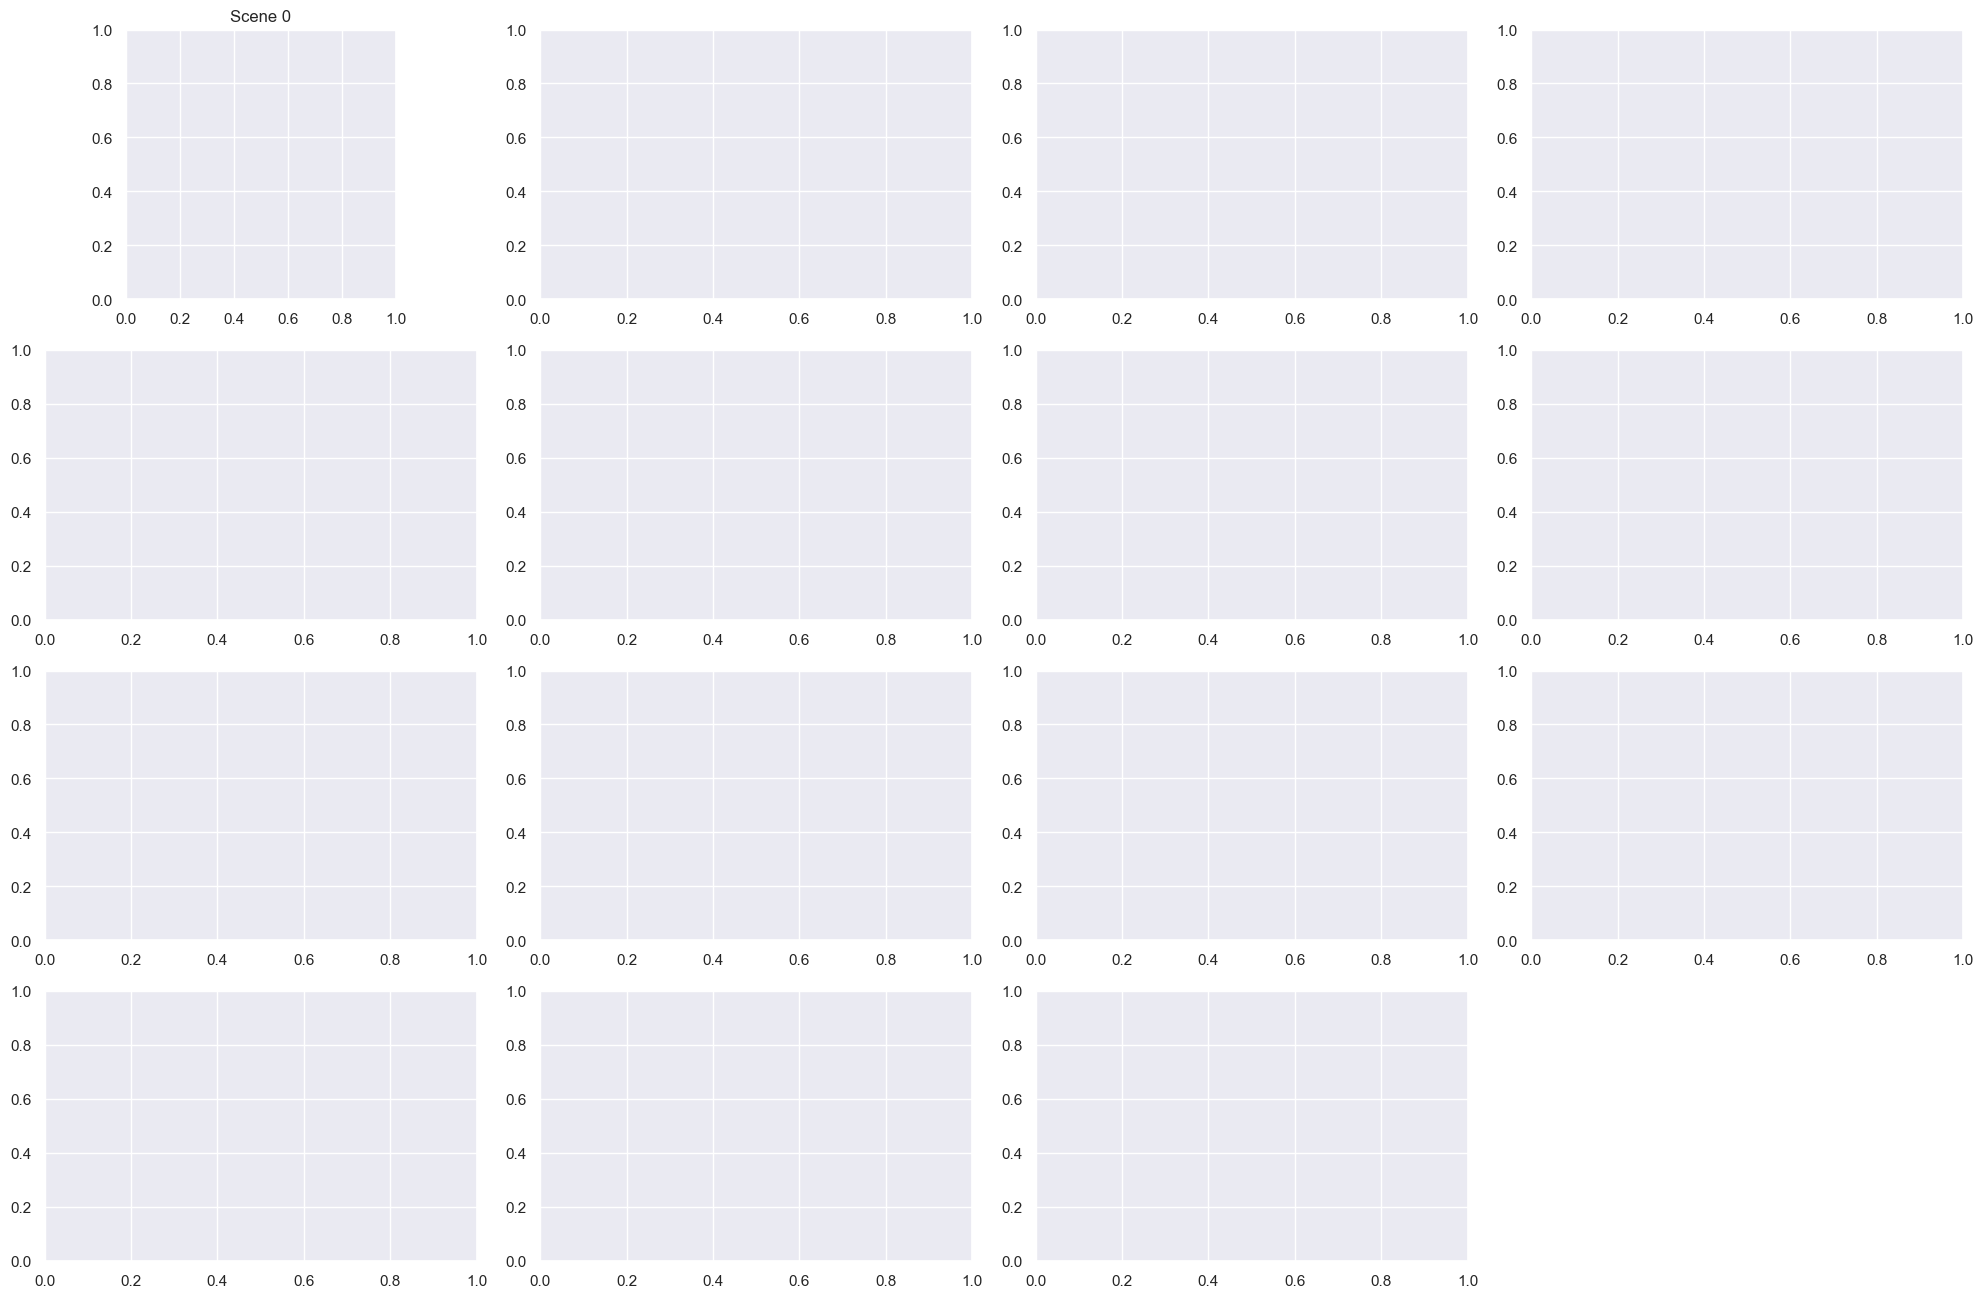

In [ ]:
import cv2
import numpy as np
 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('challenge.mp4')
 

number_of_videos_object_Tracked_using_Kalman_Filters = 0

list_of_Object_Tracked_Videos_in_Object_Tracked_Files = []

number_of_videos_object_Tracked_show_using_Kalman_Filters = 0


while( True ):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    number_of_videos_object_Tracked_using_Kalman_Filters = number_of_videos_object_Tracked_using_Kalman_Filters + 1

    
    if number_of_videos_object_Tracked_using_Kalman_Filters % 10 == 1 :
        
        list_of_Object_Tracked_Videos_in_Object_Tracked_Files.append( frame )
        
        number_of_videos_object_Tracked_show_using_Kalman_Filters = number_of_videos_object_Tracked_show_using_Kalman_Filters + 1
        
    if number_of_videos_object_Tracked_show_using_Kalman_Filters >= 16 :
        
        break
        
    
 
# When everything done, release the video capture object
#cap.release()
 
# Closes all the frames
#cv2.destroyAllWindows()

import os
import matplotlib.pyplot as plt
import PIL
#%matplotlib inline

import seaborn as sns

sns.set_theme()

rows = 4
#os.chdir('/home/brian/Desktop/cats/')
#files = os.listdir('/home/brian/Desktop/cats/')

#define subplots
fig, ax = plt.subplots(4, 4, figsize=(20,13))
fig.tight_layout()

#define data
#x = [1, 2, 3]
#y = [7, 13, 24]


for num, x in enumerate(list_of_Object_Tracked_Videos_in_Object_Tracked_Files ):
    
    img = list_of_Object_Tracked_Videos_in_Object_Tracked_Files[ num ]#PIL.Image.open(x)
    #ax = plt.subplot(rows , 4 , num+1 )
    #plt.size( 20 , 13 )
    #plt.title("Scene {}".format( str( num )))#x.split('.')[0])
    plt.axis('off')
    #ax.set_size( 20 , 13 )
    #plt.set_size( 20 , 13 )
    ax[ num // 4 , num % 4 ].set_title( "Scene {}".format( str( num ) ) )
    
    ax[ num // 4 , num % 4 ].imshow( img )
    
    ax[ num // 4 , num % 4 ].set_axis_off()
    
    

In [ ]:
"""
!pip install bokeh

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import cv2
import time
output_notebook()

cap = cv2.VideoCapture( '/kaggle/working/challenge.mp4' )
ret, frame = cap.read()

if ret == True:
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame=cv2.flip(frame, -1) # because Bokeh flips vertically
    width=frame.shape[1]
    height=frame.shape[0]
    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)
    while True:
        ret, frame = cap.read()
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
        frame=cv2.flip(frame, -1)
        myImage.data_source.data['image']=[frame]
        push_notebook()
        time.sleep(0.3)
"""

'\n!pip install bokeh\n\nfrom bokeh.plotting import figure\nfrom bokeh.io import output_notebook, show, push_notebook\nimport cv2\nimport time\noutput_notebook()\n\ncap = cv2.VideoCapture( \'/kaggle/working/challenge.mp4\' )\nret, frame = cap.read()\n\nif ret == True:\n    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image\n    frame=cv2.flip(frame, -1) # because Bokeh flips vertically\n    width=frame.shape[1]\n    height=frame.shape[0]\n    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)\n    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)\n    show(p, notebook_handle=True)\n    while True:\n        ret, frame = cap.read()\n        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)\n        frame=cv2.flip(frame, -1)\n        myImage.data_source.data[\'image\']=[frame]\n        push_notebook()\n        time.sleep(0.3)\n'

In [ ]:
from IPython.display import HTML
HTML("""
<video width=1024 controls>
  <source src='/kaggle/working/challenge.mp4' type="video/mp4">
</video>
""")